In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import cv2
from tqdm import tqdm
import random

In [2]:
DATASET_PATH = "/kaggle/input/gtsrb-german-traffic-sign"

In [3]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, "Train.csv"))
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
IMG_SIZE = 48  
NUM_CLASSES = 43

In [6]:
X, y = [], []

# Load images
for i in tqdm(range(len(train_df))):
    img_path = os.path.join(DATASET_PATH, train_df.loc[i, "Path"])  

    if not os.path.exists(img_path):
        print(f" Missing file: {img_path}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        print(f" Corrupted file: {img_path}")
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  
    X.append(image)
    y.append(train_df.loc[i, "ClassId"])

print(f" Successfully loaded {len(X)} images!")

100%|██████████| 39209/39209 [02:53<00:00, 226.08it/s]

 Successfully loaded 39209 images!


In [7]:
X = np.array(X) / 255.0  
y = to_categorical(np.array(y), NUM_CLASSES)  

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f" Loaded {len(X_train)} training and {len(X_val)} validation images!")

 Loaded 31367 training and 7842 validation images!


In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,  # Traffic signs are directional, so no flip
    fill_mode="nearest"
)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361,067 (1.38 MB)

 Trainable params: 361,067 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks: Early Stopping & Learning Rate Reduction
"""early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# Train the Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stopping, reduce_lr])
"""

In [12]:
EPOCHS = 20
BATCH_SIZE = 64

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.1465 - loss: 3.1995 - val_accuracy: 0.6112 - val_loss: 1.2744
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.5356 - loss: 1.4359 - val_accuracy: 0.8571 - val_loss: 0.5314
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.7122 - loss: 0.8726 - val_accuracy: 0.9398 - val_loss: 0.2402
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.8067 - loss: 0.5813 - val_accuracy: 0.9756 - val_loss: 0.1159
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.8666 - loss: 0.4062 - val_accuracy: 0.9871 - val_loss: 0.0808
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.9001 - loss: 0.3127 - val_accuracy: 0.9875 - val_loss: 0.0511
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.9191 - loss: 0.2496 - val_accuracy: 0.9912 - val_loss: 0.0332
Epoch 8/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.9336 - loss: 0.2026 - val_accurac

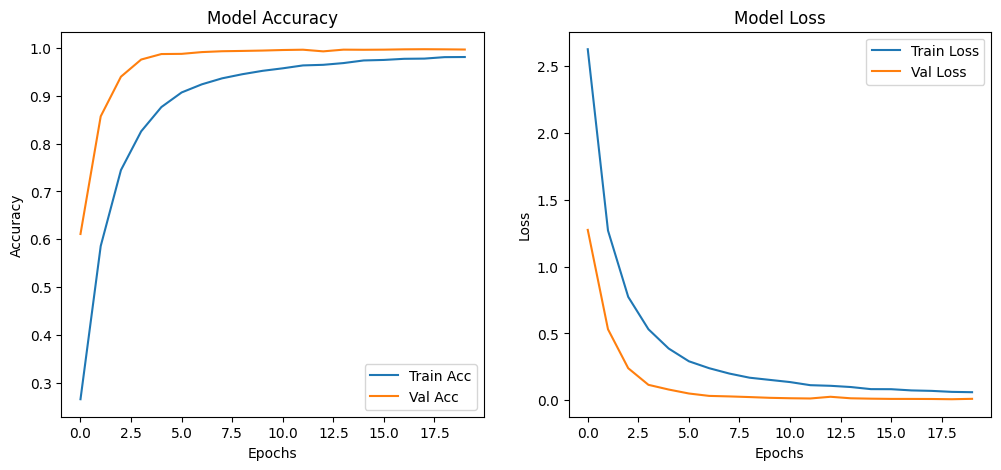

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [14]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, "Test.csv"))

X_test, y_test = [], []
for i in tqdm(range(len(test_df))):
    img_path = os.path.join(DATASET_PATH, test_df.loc[i, "Path"])
    image = cv2.imread(img_path)
    
    if image is None:
        print(f" Skipping corrupted file: {img_path}")
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    X_test.append(image)
    y_test.append(test_df.loc[i, "ClassId"])

100%|██████████| 12630/12630 [01:02<00:00, 201.11it/s]


In [15]:

X_test = np.array(X_test) / 255.0
y_test = to_categorical(np.array(y_test), NUM_CLASSES)

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9786 - loss: 0.0933
Test Accuracy: 97.88%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


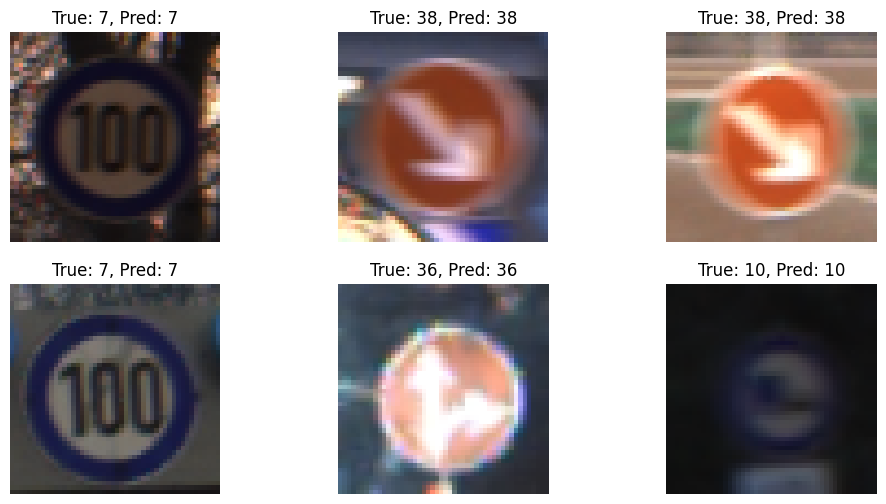

In [17]:
# Visualize Predictions
def plot_predictions(model, X, y, num_samples=6):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(X)), num_samples)
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = np.argmax(y[idx])
        pred_label = np.argmax(model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3)))
        
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis("off")
    plt.show()

plot_predictions(model, X_test, y_test)